# Construction of curated Wzy HMMs for improved annotation

## Setup

### Define file paths

In [1]:
from pathlib import Path

from matplotlib.pyplot import annotate

parent_path = Path('/Users/tsta0015/Programming/Wzy_Analysis')
jk_path = parent_path / 'from_JK'
jk_hmms = jk_path / 'HMM'
hmm_path = parent_path / 'hmms'
ent_path = parent_path / 'ent_test'
result_path = parent_path / 'results'

### Load ground truths
This table contains the result from the structural clustering.

In [2]:
import pandas as pd
truths = pd.read_csv(result_path / 'structure_truths.csv.zst', index_col=0)

### Define functions for HMM construction

In [3]:
from pathlib import Path
from pyhmmer import __version__ as pyhmmer_version
from pyhmmer.easel import Alphabet, SequenceFile
from pyhmmer.plan7 import Builder, Background
from pytrimal import RepresentativeTrimmer, AutomaticTrimmer, Alignment, __version__ as pytrimal_version
from pyfamsa import Aligner, Sequence, __version__ as pyfamsa_version

_hmm_alphabet = Alphabet.amino()
_trim_identity_threshold = 0.5
_trim_method = 'automated1'
_id_trimmer = RepresentativeTrimmer(identity_threshold=_trim_identity_threshold)
_auto_trimmer = AutomaticTrimmer(method=_trim_method)
_aligner = Aligner()
_builder = Builder(_hmm_alphabet)
_background = Background(_hmm_alphabet)

def build_hmm(seq_file: Path, out_path: Path = hmm_path):
    protein_name = seq_file.stem
    names, seqs = [], []  # Store the MSA IDs and GappedSequences in lists for passing to Pytrimal
    for _seq in _aligner.align((Sequence(_seq.name, _seq.sequence) for _seq in SequenceFile(seq_file))):
        names.append(_seq.id), seqs.append(_seq.sequence)  # Sort IDs and seqs for pytrimal
    msa = Alignment(names, seqs, 'protein')
    desc = (f'aligned with pyfamsa v{pyfamsa_version}; trimmed with pytrimal '
            f'v{pytrimal_version} at {_trim_identity_threshold} identity threshold')
    reduced_msa = _id_trimmer.trim(msa)
    reduced_msa_pyhmmer = reduced_msa.to_pyhmmer().digitize(_hmm_alphabet)  # Trim MSA and digitize
    reduced_msa_pyhmmer.name = f'{protein_name}_reduced'.encode()  # Set the MSA (+ subsequent HMM) as cluster name
    reduced_hmm, _, _ = _builder.build_msa(reduced_msa_pyhmmer, _background)
    reduced_hmm.description = f'{desc}; built with pyhmmer v{pyhmmer_version}'.encode()
    reduced_hmm.accession = f'{protein_name}.1'.encode()
    with open(out_path / f'{protein_name}_reduced.hmm', 'wb') as f:
        reduced_hmm.write(f)
    trimmed_msa = _auto_trimmer.trim(reduced_msa)
    trimmed_msa_pyhmmer = trimmed_msa.to_pyhmmer().digitize(_hmm_alphabet)  # Trim MSA and digitize
    trimmed_msa_pyhmmer.name = f'{protein_name}_trimmed'.encode()  # Set the MSA (+ subsequent HMM) as cluster name
    trimmed_hmm, _, _ = _builder.build_msa(trimmed_msa_pyhmmer, _background)
    trimmed_hmm.description = f'{desc} and trimmed with the {_trim_method} method; built with pyhmmer v{pyhmmer_version}'.encode()
    trimmed_hmm.accession = f'{protein_name}.2'.encode()
    with open(out_path / f'{protein_name}_trimmed.hmm', 'wb') as f:
        trimmed_hmm.write(f)
    return reduced_hmm, trimmed_hmm

## Build HMMs

In [4]:
hmms = []
for i in ('A', 'B', 'C'):
    # build_hmm returns a tuple of HMMs, so we extend the list
    hmms.extend(build_hmm(jk_path / f"Wzy{i}.faa"))

### Load other HMMs

In [5]:
from pyhmmer.plan7 import HMMFile
for hmm in Path(jk_hmms).glob('*.hmm'):
    with HMMFile(hmm, db=False) as hmm:
        hmms.append(hmm.read())

### Summarise HMM metrics

In [6]:
import pandas as pd
hmm_metrics = pd.DataFrame({
    hmm.name.decode(): {
        'accession': hmm.accession.decode(),
        'description': hmm.description.decode(),
        '# sequences': hmm.nseq,
        '# effective sequences': hmm.nseq_effective,
        '# nodes': hmm.M,
        'Mean match information': hmm.mean_match_information(_background),
        'Mean match relative entropy': hmm.mean_match_relative_entropy(_background)
    } for hmm in hmms
})
hmm_metrics.to_csv(result_path / 'hmm_metrics.csv.zst', index_label='HMM metric', compression='zstd')

## Test HMMs

### Define hmmsearch function for testing

In [7]:
from pyhmmer import hmmsearch
from pyhmmer.easel import SequenceFile, Alphabet, GeneticCode
import pandas as pd
import numpy as np

def run_hmmsearch(seq_file, seq_alphabet: Alphabet) -> pd.DataFrame:
    _seqs = SequenceFile(seq_file, format='fasta', alphabet=seq_alphabet, digital=True).read_block()
    if seq_alphabet != _hmm_alphabet:
        _seqs = _seqs.translate(genetic_code=GeneticCode(11))
    _ids = [s.name.decode() for s in _seqs]
    _r = []
    for hmm_hits in hmmsearch(hmms, _seqs, alphabet=_hmm_alphabet, background=_background, parallel='targets'):
        # Create a dictionary mapping sequence names to hits for this HMM query
        hits = {hit.name.decode(): hit for hit in hmm_hits}
        hmm_name = hmm_hits.query.name.decode()
        # For each sequence, record the evalue and score, using defaults if no hit was found
        _r += ({
            'hmm': hmm_name, 'seq_id': seq_id,
            'evalue': hit.evalue if (hit := hits.get(seq_id)) else np.inf,  # set default to np.inf
            'score': hit.score if hit else 0  # set default to 0
        } for seq_id in _ids)
    
    df = pd.DataFrame(_r).pivot(index='seq_id', columns='hmm', values=['evalue', 'score'])
    
    # Add 'best' columns by applying argmin/max to the respective MultiIndex levels
    best_cols = [('evalue', 'best'), ('score', 'best')]
    
    # Calculate best e-value
    evalue_slice = df['evalue']
    df[best_cols[0]] = evalue_slice.idxmin(axis=1)
    # Use np.isinf() which works on DataFrames
    df.loc[np.isinf(evalue_slice).all(axis=1), best_cols[0]] = "No hit"

    # Calculate best score
    score_slice = df['score']
    df[best_cols[1]] = score_slice.idxmax(axis=1)
    df.loc[(score_slice == 0).all(axis=1), best_cols[1]] = "No hit"

    # Reorder columns and flatten the MultiIndex
    df = df[best_cols + [col for col in df.columns if col not in best_cols]]
    df.columns = df.columns.to_series().apply(lambda x: " ".join(x))
    return df

### Test new HMMs on ground truth sequences

In [8]:
truth_results = pd.concat(run_hmmsearch(jk_path / f'{i}.faa', Alphabet.amino()) for i in ('WzyA', 'WzyB', 'WzyC', 'ligases'))
truth_results.index = truth_results.index.str.lower()
truth_results = truth_results.join(truths)
truth_results.to_csv(result_path / 'truth_hmmsearch_results.csv.zst', index_label='ID', compression='zstd')

Check that top HMMs by evalue and (bit)score are the same

In [11]:
len(truth_results[truth_results['score best'] != truth_results['evalue best']])

0

Find out which HMMs performed best

In [15]:
truth_results[truth_results['Truth'] != 'ligases']['score best'].value_counts()

score best
WzyC_reduced      343
WzyA_reduced      310
WzyB_reduced      183
Wzy_O6_O28         23
glyco_rpt_poly     16
O-ag_pol_Wzy        6
Wzy_C               2
Wzy_Strepto         2
No hit              1
WzyE                1
WcaD                1
DUF6369             1
Name: count, dtype: int64

Our reduced HMMs accounted for most of the top hits! 343 + 310 + 183 = 836 = 94%.
Trimmed HMMs were never the top hit - disregard these going forward.

Inspect ligase hits and their top HMMs

In [14]:
len(truth_results[(truth_results['Truth'] == 'ligases')])

889

In [18]:
truth_results[(truth_results['Truth'] == 'ligases') & (truth_results['score WzyC_reduced'] != 0)][['score WzyC_reduced', 'evalue WzyC_reduced']].describe()

,score WzyC_reduced,evalue WzyC_reduced
count,15.000000,1.500000e+01
mean,67.432270,6.106395e-12
std,17.593441,2.362713e-11
min,31.077930,4.128709e-30
25%,56.469147,3.198876e-25
50%,70.598419,9.383416e-23
75%,79.134258,1.892653e-18
max,94.848259,9.151333e-11


In [43]:
truth_results.value_counts('score best')

score best
WzyC_reduced      349
WzyA_reduced      310
WzyB_reduced      183
Wzy_O6_O28         23
glyco_rpt_poly     16
Wzy_C              10
O-ag_pol_Wzy        6
No hit              2
Wzy_Strepto         2
DUF6369             1
WcaD                1
WzyE                1
Wzy_C_2             1
Name: count, dtype: int64

In [47]:
truth_results.value_counts(['Truth', 'score best'])

Truth    score best    
WzyC     WzyC_reduced      343
WzyA     WzyA_reduced      309
WzyB     WzyB_reduced      183
         Wzy_O6_O28         23
         glyco_rpt_poly     16
ligases  Wzy_C               8
WzyB     O-ag_pol_Wzy        6
ligases  WzyC_reduced        6
WzyC     Wzy_Strepto         2
         Wzy_C               2
WzyA     No hit              1
ligases  No hit              1
WzyC     DUF6369             1
         WcaD                1
WzyB     WzyE                1
         WzyA_reduced        1
ligases  Wzy_C_2             1
Name: count, dtype: int64

In [33]:
clusters = ['WzyA', 'WzyB', 'WzyC']
cluster_mask = truth_results['Truth'].isin(clusters)
match_mask = truth_results['Truth'] == truth_results['score best'].str.removesuffix('_reduced')
mismatch_mask = cluster_mask & ~match_mask
truth_results[mismatch_mask][['best', 'Truth']]

In [37]:
truth_results[cluster_mask].groupby('Truth')[
    [f'evalue {c}_reduced' for c in clusters]].agg(['min']).style.format('{:.2e}')

,evalue WzyA_reduced,evalue WzyB_reduced,evalue WzyC_reduced
,min,min,min
Truth,,,
WzyA,1.36e-66,5.62e-06,2.74e-05
WzyB,2.20e-39,1.21e-60,1.85e-15
WzyC,2.57e-07,4.69e-15,2.83e-59


In [38]:
truth_results[match_mask].groupby('Truth')[
    [f'evalue {c}_reduced' for c in clusters]].agg(['min']).style.format('{:.2e}')

,evalue WzyA_reduced,evalue WzyB_reduced,evalue WzyC_reduced
,min,min,min
Truth,,,
WzyA,1.36e-66,5.62e-06,2.74e-05
WzyB,1.96e-06,1.21e-60,1.85e-15
WzyC,2.57e-07,4.69e-15,2.83e-59


In [39]:
truth_results[mismatch_mask].groupby('Truth')[
    [f'evalue {c}_reduced' for c in clusters]].agg(['min']).style.format('{:.2e}')

,evalue WzyA_reduced,evalue WzyB_reduced,evalue WzyC_reduced
,min,min,min
Truth,,,
WzyA,inf,inf,inf
WzyB,2.20e-39,9.28e-42,1.28e-09
WzyC,inf,3.94e-05,2.32e-28


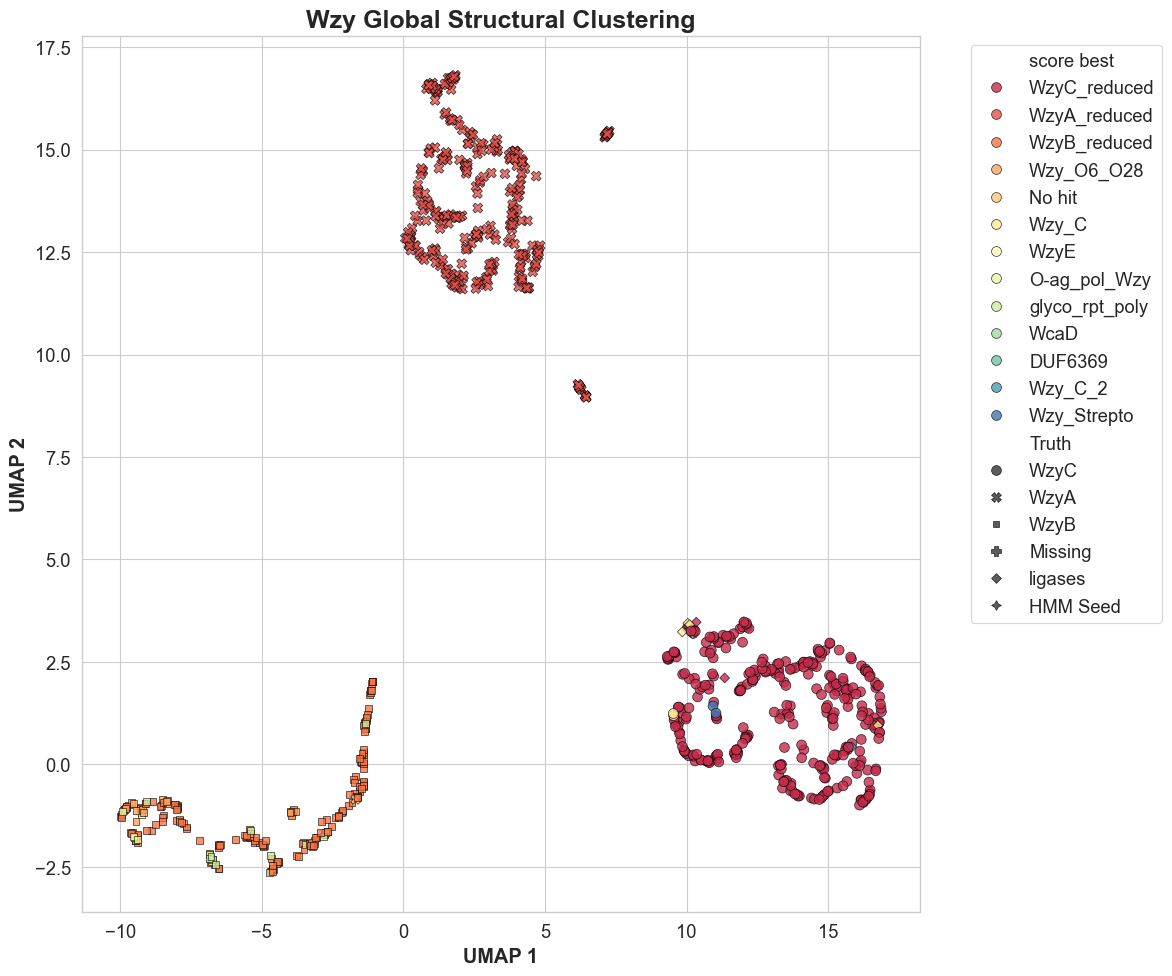

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=pd.read_csv(result_path / 'structural_clustering_results.csv.zst', index_col=0).join(
        truth_results[['score best']]),
    x='UMAP 1',
    y='UMAP 2',
    hue='score best',      # Color points by Leiden cluster
    style='Truth',     # Shape points by ground truth
    palette='Spectral',
    s=50,              # Increased size for better visibility of shapes
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8
)
plt.title('Wzy Global Structural Clustering', fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
plt.tight_layout() # Adjust plot to prevent legend from being cut off
plt.show()

### Test new HMMs on _Enterobacterales_
Wzy sequences from CPS/KPS clusters defined in Holt et al., ISME 2022.

#### Define function for downloading and hmmsearching sequences

In [16]:
import requests, io
from pyhmmer.easel import Alphabet

def get_ent_results(mol: str):
    url = (f'https://raw.githubusercontent.com/rmostowy/'
           f'fastKaptive/refs/heads/master/reference-db/'
           f'{mol}/00_extended/database/genes.fa')
    # Use a session for better performance and connection management
    with requests.Session() as session:
        response = session.get(url)
        response.raise_for_status()  # This will raise an error for bad responses (4xx or 5xx)
        # Wrap the downloaded content (bytes) in a file-like object
        results = run_hmmsearch(io.BytesIO(response.content), Alphabet.dna())
        results['Molecule'] = mol.upper()
        return results

#### Get _Enterobacterales_ hmmsearch results and save

In [17]:
ent_results = pd.concat(map(get_ent_results, ('kps', 'cps')))
ent_regex = r'(?P<Species>\w+)-(?P<Locus>\w+)__(?P<Gene>\w+)'
ent_results[['Species', 'Locus', 'Gene']] = ent_results.index.str.extract(ent_regex).values
ent_results.to_csv(result_path / 'ent_results.csv.zst', index_label='ID', compression='zstd')

#### Summarise results

In [50]:
len(ent_results[ent_results['Molecule'] == 'CPS']['Species'].unique())

19

In [45]:
# Identify score columns (excluding 'score best')
score_cols = [col for col in ent_results.columns if col.startswith('score ') and col != 'score best']
# Create a temporary DataFrame to calculate max scores
df_scores = ent_results.loc[ent_results['Molecule'] == 'CPS'].copy()
df_scores['max_score'] = df_scores[score_cols].max(axis=1)
# Find the best hit per locus
locus_summary = (
    df_scores.sort_values('max_score', ascending=False)
             .drop_duplicates(['Species', 'Locus'])
             [['Species', 'Locus', 'score best', 'max_score']]
             .set_index(['Species', 'Locus'])
)
locus_summary

score best   max_score
Species          Locus                        
Klebsiella       NL532        WcaD  361.324585
                 NL473        WcaD  360.090790
                 K108         WcaD  360.090790
Escherichia      NL217  Wzy_O6_O28  310.959717
Escherichia_coli O39    Wzy_O6_O28  308.323029
...                            ...         ...
                 O101       No hit    0.000000
                 O52        No hit    0.000000
                 O60        No hit    0.000000
Escherichia      NL401      No hit    0.000000
                 NL362      No hit    0.000000

[994 rows x 2 columns]

In [46]:
locus_summary.value_counts('score best')

score best
WzyA_reduced      324
WzyC_reduced      313
WzyB_reduced      185
No hit             92
Wzy_O6_O28         36
glyco_rpt_poly     21
DUF6337             9
EpsG                4
O-ag_pol_Wzy        4
DUF6369             3
WcaD                3
Name: count, dtype: int64

902 hits = 90.7%, 324 + 313 + 185 = 822